# Notebook used to visualize the three step labeling procedure, as depicted in the data descriptor

## Load packages and basic dataset information

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import patches
import h5py
import pandas as pd
import os
import sys
from pathlib import Path
from datetime import datetime
from datetime import timedelta
import math
import pdb
import scipy
# Add project path to path for import
project_path = os.path.abspath("..")
if project_path not in sys.path:
    sys.path.append(project_path)

# Add module path to path for import
module_path = os.path.abspath("../data_utility/data_utility.py")
if module_path not in sys.path:
    sys.path.append(module_path)
    
from data_utility import CREAM_Day # class to work with a day of the CREAM Dataset

# Intentional replication is necessary
%load_ext autoreload
# Reload all modules every time before executing the Python code typed.
%autoreload 2 
# Import some graphical modules
from IPython.display import display, clear_output
from ipywidgets import Button, Layout, ButtonStyle, HBox, VBox, widgets, Output
from IPython.display import SVG, display, clear_output

import subprocess
import glob

In [ ]:
PATH_TO_DATA = os.path.abspath(os.path.join("..", "..", "Datasets", "CREAM", "X8"))
ALL_DAYS = ["2018-08-23" , "2018-08-24" , "2018-08-25",  "2018-08-26" , "2018-08-27" , "2018-08-28" ,
"2018-08-29", "2018-08-30", "2018-08-31", "2018-09-01", "2018-09-02" , "2018-09-03" ,  "2018-09-04" ,
"2018-09-05", "2018-09-06", "2018-09-07", "2018-09-08" , "2018-09-09" , "2018-09-10", "2018-09-11", "2018-09-12" 
"2018-09-13" ,"2018-09-14" ,"2018-09-15" ,  "2018-09-16", "2018-09-17", "2018-09-18","2018-09-19"  , "2018-09-20" ,
"2018-09-21" , "2018-09-22" ,  "2018-09-23" ,"2018-09-24" ,"2018-09-25" ,"2018-09-26" , "2018-09-27", "2018-09-28" ,
"2018-09-29" , "2018-09-30" , "2018-10-01" ,"2018-10-02" , "2018-10-03" ,"2018-10-04", "2018-10-05" , "2018-10-06" ,
"2018-10-07", "2018-10-08" ]

In [4]:
#necessary for the plotting
# Load the events 
day_path = os.path.join(PATH_TO_DATA, "2018-08-24") #arbitrary day to initialize the object
current_CREAM_day = CREAM_Day(cream_day_location=day_path,use_buffer=True, buffer_size_files=2) 

# Load the electrical component events (the raw ones)
all_component_events = current_CREAM_day.load_component_events(os.path.join(PATH_TO_DATA, "component_events.csv"), filter_day=False)

# Load the product and the maintenance events (the raw ones, per minute events) and filter for the day
all_maintenance_events = current_CREAM_day.load_machine_events(os.path.join(PATH_TO_DATA, "maintenance_events.csv"), raw_file=False, filter_day=False)
all_product_events = current_CREAM_day.load_machine_events(os.path.join(PATH_TO_DATA, "product_events.csv"), raw_file=False, filter_day=False)


In [5]:
# Load an event 
event = all_product_events[all_product_events.Event_Type == "espresso"].iloc[83]
cream_day = CREAM_Day(cream_day_location=os.path.join(PATH_TO_DATA, str(event.Date)), use_buffer=True, buffer_size_files=10)
start = event.Start_Timestamp # - timedelta(seconds=0.5)
end = event.End_Timestamp + timedelta(seconds=2)
duration = (end - start).total_seconds()
voltage, current = cream_day.load_time_frame(start, duration=duration, return_noise=False)

# Plot of the three step labeling procedure

/Users/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


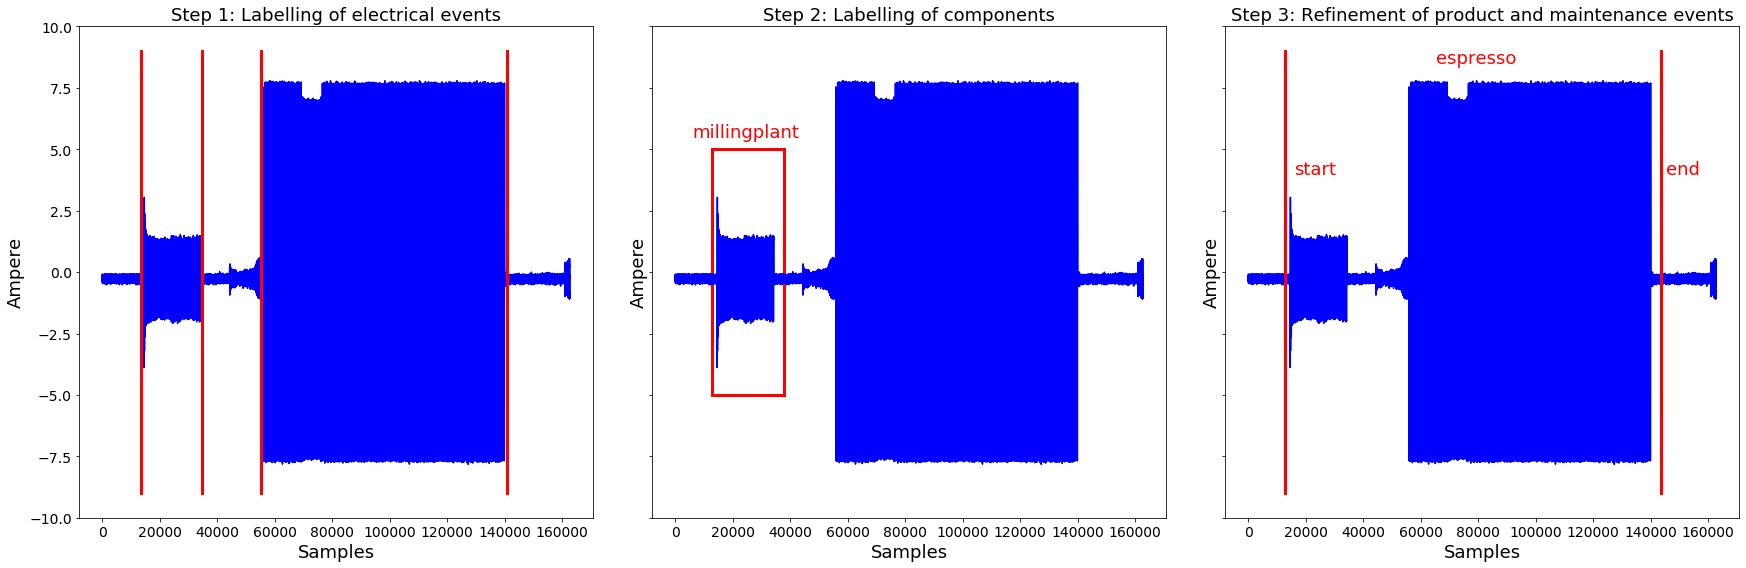

In [6]:
# We have adapted the exact start and end index slightly for visualization purposes. The offset does not matcch exactly.

fig, axs = plt.subplots(1,3,sharex=True, sharey=True)
fig.set_size_inches(25, 8)

fontdict_text = {"size" : 18}

for step, ax in enumerate(axs, start=1):
    ax.plot(current, color="b")
    ax.set_xlabel("Samples",fontdict=fontdict_text)
    ax.set_ylabel("Ampere", fontdict=fontdict_text)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.tick_params(axis='both', which='minor', labelsize=10)
    ax.set_ylim((-10,10))
    
    # Now for the different steps of the procedure we insert the labels that were added in the step
    if step == 1:
        # Here we manually add the red circles where the labeling took place
        ax.set_title("Step 1: Labelling of electrical events", fontdict=fontdict_text)
        
        events_roi = all_component_events[(all_component_events.Timestamp >= event.Start_Timestamp) & (all_component_events.Timestamp <= event.End_Timestamp)]
        
        # We adjust the labels a little bit, as we want to show the optimal labeling case.
        # Small deviations in the labelin can of course alway occur.
        for i, e in enumerate(events_roi.itertuples()):
            
            if i == 0:
                e_idx = cream_day.get_index_from_timestamp(start, e.Timestamp+timedelta(seconds=0.6))
            else:
                e_idx = cream_day.get_index_from_timestamp(start, e.Timestamp+timedelta(seconds=0.2))
            ax.axvline(e_idx, color="r", ymin=0.05, ymax=0.95,  linewidth=3)
        
    elif step == 2:
        #TODO add arrow and label of one component!
        #TODO maybe zoom in
        ax.set_title("Step 2: Labelling of components", fontdict=fontdict_text)
        start_idx = cream_day.get_index_from_timestamp(start, start+timedelta(seconds=2))
        
          
        # Bounding rectangle around the millingplant event
        rect = patches.Rectangle((start_idx,-5),25000,10,linewidth=3,edgecolor='r',facecolor='none')
        ax.add_patch(rect)
        
        ax.text(start_idx-7000,5.5, 'millingplant',rotation=0, color="r", fontdict=fontdict_text) 

        start_idx + 2500
    else:
        ax.set_title("Step 3: Refinement of product and maintenance events", fontdict=fontdict_text)
        
        # Add the start and end lines
        start_idx = cream_day.get_index_from_timestamp(start, start+timedelta(seconds=2))
        end_idx = cream_day.get_index_from_timestamp(start, event.End_Timestamp-timedelta(seconds=1))
        ax.axvline(start_idx, color="r", ymin=0.05, ymax=0.95, linewidth=3)
        ax.text(start_idx+3000,4,'start',rotation=0, color="r", fontdict=fontdict_text)
        ax.axvline(end_idx, color="r", ymin=0.05, ymax=0.95, linewidth=3)
        ax.text(end_idx+2000,4,'end',rotation=0, color="r", fontdict=fontdict_text )
        
        ax.text((end_idx - start_idx)/2, 8.5, "espresso", color="r", fontdict=fontdict_text)
        
fig.tight_layout()    
fig.show()
plt.savefig("./Figure_2.pdf")